In [ ]:
import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
# import ASRE models
cur_dir = os.getcwd()
ASREp_dir = os.path.join(os.path.dirname(os.path.dirname(cur_dir)))
sys.path.append(ASREp_dir)
import ASREp.ground_deformation_models as gdm
import ASREp
import pandas as pd
from scipy import interpolate
np.set_printoptions(threshold=np.inf)

In [ ]:
def prepare_greenfield_disp(val_data_dir, vl, beamX):
    ## Prepare Ux-GF
    # Read Ux-GF and Uz-GF
    dispX_gf_file = os.path.join(val_data_dir, f'FranzaDeJong-'
                        f"VL{str(vl*100).replace('.', 'p')}-Ux-GF.csv")
    dispX_gf = pd.read_csv(dispX_gf_file, header=None)

    dispZ_gf_file = os.path.join(val_data_dir, f'FranzaDeJong-'
                        f"VL{str(vl*100).replace('.', 'p')}-Uz-GF.csv")
    dispZ_gf = pd.read_csv(dispZ_gf_file, header=None)
    # Add the left half of Ux-GF and Uz-GF
    left_half = dispX_gf.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispX_gf = pd.concat([left_half, dispX_gf])
    dispX_gf = dispX_gf.sort_values(by = 0).reset_index(drop = True)

    left_half = dispZ_gf.copy()
    left_half[0] = -left_half[0]
    dispZ_gf = pd.concat([left_half, dispZ_gf])
    dispZ_gf = dispZ_gf.sort_values(by = 0).reset_index(drop = True)
    # Interpolate the dispX_gf with beamX mesh
    f = interpolate.interp1d(dispX_gf[0], dispX_gf[1], fill_value='extrapolate')
    dispX_gf = f(beamX)

    f = interpolate.interp1d(dispZ_gf[0], dispZ_gf[1], fill_value='extrapolate')
    dispZ_gf = f(beamX)
    return dispX_gf/1000, dispZ_gf/1000

def plot_verification(val_data_dir, frame_id, qz_id, beamX, model, axes, model_el = None):
    
    ## Prepare Ux-GF
    # Read Ux-GF and Uz-GF
    dispX_gf_file = os.path.join(val_data_dir, "FranzaDeJong-VL2p0-Ux-GF.csv")
    dispX_gf = pd.read_csv(dispX_gf_file, header=None)

    dispZ_gf_file = os.path.join(val_data_dir, "FranzaDeJong-VL2p0-Uz-GF.csv")
    dispZ_gf = pd.read_csv(dispZ_gf_file, header=None)

    dispL_asre_file =  os.path.join(val_data_dir, f'{frame_id}_'
                        f"{qz_id}_ux.csv")
    dispL_asre_Franza = pd.read_csv(dispL_asre_file, header=None)

    dispV_asre_file =  os.path.join(val_data_dir, f'{frame_id}_'
                        f"{qz_id}_uz.csv")
    dispV_asre_Franza = pd.read_csv(dispV_asre_file, header=None)

    # Sort the disp in file from left to right
    left_half = dispX_gf.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispX_gf = pd.concat([left_half, dispX_gf])
    dispX_gf = dispX_gf.sort_values(by = 0).reset_index(drop = True)
    
    left_half = dispZ_gf.copy()
    left_half[0] = -left_half[0]
    dispZ_gf = pd.concat([left_half, dispZ_gf])
    dispZ_gf = dispZ_gf.sort_values(by = 0).reset_index(drop = True)
    
    left_half = dispL_asre_Franza.copy()
    left_half[0] = -left_half[0]
    left_half[1] = -left_half[1]
    dispL_asre_Franza = pd.concat([left_half, dispL_asre_Franza])
    dispL_asre_Franza = dispL_asre_Franza.sort_values(by = 0).reset_index(drop = True)

    left_half = dispV_asre_Franza.copy()
    left_half[0] = -left_half[0]
    dispV_asre_Franza = pd.concat([left_half, dispV_asre_Franza])
    dispV_asre_Franza = dispV_asre_Franza.sort_values(by = 0).reset_index(drop = True)
    # Interpolate the dispX_gf with beamX mesh
    f = interpolate.interp1d(dispX_gf[0], dispX_gf[1], fill_value='extrapolate')
    dispX_gf = f(beamX)

    f = interpolate.interp1d(dispZ_gf[0], dispZ_gf[1], fill_value='extrapolate')
    dispZ_gf = f(beamX)

    f = interpolate.interp1d(dispL_asre_Franza[0], dispL_asre_Franza[1], fill_value='extrapolate')
    dispL_asre_Franza = f(beamX)

    f = interpolate.interp1d(dispV_asre_Franza[0], dispV_asre_Franza[1], fill_value='extrapolate')
    dispV_asre_Franza = f(beamX)
    
    axes[0].plot(beamX, dispX_gf, 'r:', label = 'experiment')
    axes[1].plot(beamX, dispZ_gf, 'r:', label = 'experiment')

    axes[0].plot(beamX, dispL_asre_Franza, 'b', label = 'ASRE_Franza')
    axes[1].plot(beamX, -dispV_asre_Franza, 'b', label = 'ASRE_Franza')
    
    if model_el is not None:
        axes[0].plot(beamX, model.beam_DispL[model.footing_nodes_ind]*1000, 'bx', label = 'ASREp_ep')
        axes[1].plot(beamX, model.beam_DispV[model.footing_nodes_ind]*1000, 'bx', label = 'ASREp_ep')

        axes[0].plot(beamX, model_el.beam_DispL[model.footing_nodes_ind]*1000, 'b^', label = 'ASREp_el')
        axes[1].plot(beamX, model_el.beam_DispV[model.footing_nodes_ind]*1000, 'b^', label = 'ASREp_el')
    else:
        axes[0].plot(beamX, model.beam_DispL[model.footing_nodes_ind]*1000, 'bx', label = 'ASREp')
        axes[1].plot(beamX, model.beam_DispV[model.footing_nodes_ind]*1000, 'bx', label = 'ASREp')


    axes[0].legend()
    axes[1].legend()

    axes[0].set_title(f'{frame_id}, {qz_id}, Ux')
    axes[1].set_title(f'{frame_id}, {qz_id}, Uz')

    axes[0].set_xlim([0, 15])
    axes[1].set_xlim([0, 15])
    axes[0].set_ylim([-60, 36])
    axes[1].set_ylim([-60, 36])
    
val_data_dir = r"VerificationData"

In [3]:
import numpy as np
import openseespy.opensees as ops

# Material and geometry parameters
E = 54e9  # Young's modulus (Pa)
rho = 2700  # Density (kg/m^3)
nu = 0.3  # Poisson's ratio
t = 0.003125 * 68  # Wall thickness (m)
g = 9.81  # Gravitational acceleration (m/s^2)

mq, nq, hq = 5, 6, 2  # Mesh divisions
h = 0.0381 * 68 / hq  # Story height (m)
b = 0.0762 * 68 / mq  # Element width (m)
l = 0.258 * 68 / nq  # Element length (m)

tolerance = 1e-6
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)

# Define nodes
nodes = {}
node_id = 1

def get_node_id(x, y, z):
    """get or create a node with given coordinates."""
    global node_id
    for (x_exist, y_exist, z_exist), existing_node_id in nodes.items():
        if (abs(x - x_exist) < tolerance and
            abs(y - y_exist) < tolerance and
            abs(z - z_exist) < tolerance):
            return existing_node_id

    nodes[(x, y, z)] = node_id
    ops.node(node_id, x, y, z)
    node_id += 1
    return node_id - 1

# Define nodes in the 3D frame structure
for layer in range(3):  
    z_offset = layer * h * hq
    for col in range(7):  
        x_offset = col * b * mq  
        for row in range(2):  
            y_offset = row * l * nq
            get_node_id(x_offset, y_offset, z_offset)          

# Add fix boundary conditions
# for coords, node_i in nodes.items():
#     x, y, z = coords
#     if x == 0 and z == 0:  
#         ops.fix(node_i, 1, 1, 1, 0, 0, 0)
#     elif x == b * 6 * mq and z == 0:  
#         ops.fix(node_i, 1, 1, 1, 0, 0, 0)

# Define materials
ops.section('ElasticMembranePlateSection', 1, E, nu, t, rho)

element_id = 1
shell_elements = []

# Vertical elements
for layer in range(2 * hq):  
    for col in range(7):  
        base_x = col * b * mq
        for row in range(nq):
            base_y = row * l 
            ele_nodes = [
                get_node_id(base_x, base_y, layer * h),
                get_node_id(base_x, base_y + l, layer * h),
                get_node_id(base_x, base_y + l, layer * h + h),
                get_node_id(base_x, base_y, layer * h + h)
            ]
            ops.element("ShellMITC4", element_id, *ele_nodes, 1)
            shell_elements.append(ele_nodes)
            element_id += 1

# Horizontal elements
for layer in range(3):
    for col in range(6 * mq):
        base_x = col * b
        for row in range(nq):
            base_y = row * l
            ele_nodes = [
                get_node_id(base_x, base_y, layer * h * hq),
                get_node_id(base_x + b, base_y, layer * h * hq),
                get_node_id(base_x + b, base_y + l, layer * h * hq),
                get_node_id(base_x, base_y + l, layer * h * hq)
            ]
            ops.element("ShellMITC4", element_id, *ele_nodes, 1)
            shell_elements.append(ele_nodes)
            element_id += 1

# Calculate self-weight and apply loads
self_weight = rho * g * t  # (N/m^2)
num_of_nodes = len(nodes)
self_weight_unit = np.zeros(num_of_nodes * 6).astype(float)  

for ele_nodes in shell_elements:
    coords = np.array([ops.nodeCoord(node_id) for node_id in ele_nodes])
    vec1 = coords[1] - coords[0]  
    vec2 = coords[3] - coords[0]  
    vec3 = coords[2] - coords[1]  
    vec4 = coords[3] - coords[2]  

    # calculate the area of the quadrilateral element
    area = 0.5 * np.linalg.norm(np.cross(vec1, vec2)) + 0.5 * np.linalg.norm(np.cross(vec3, vec4))
    total_self_weight = area * self_weight  

    # apply self-weight to nodes
    for node_id in ele_nodes:
        index = (node_id - 1) * 6 + 2  # calculate the index in self_weight_unit (Z direction)
        self_weight_unit[index] += total_self_weight / 4  # evenly distribute to four nodes

# Apply loads
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
for i in range(num_of_nodes):
    node_id = i + 1  # OpenSees node IDs start from 1
    force_z = self_weight_unit[i * 6 + 2]
    if abs(force_z) > tolerance:  # only apply force to non-zero load nodes
        ops.load(node_id, 0, 0, -force_z, 0, 0, 0)

# **Query and record footing nodes**
footing_nodes_ind = []
footing_coord_x = []
footing_coord_y = []
footing_coord_z = []

for (x, y, z), node_id in nodes.items():
    if abs(z) < tolerance:  # find nodes at the base (z = 0)
        footing_nodes_ind.append(node_id)
        footing_coord_x.append(x)
        footing_coord_y.append(y)
        footing_coord_z.append(z)

# Convert to NumPy arrays
footing_nodes_ind = np.array(footing_nodes_ind).astype(int)
footing_coord_x = np.array(footing_coord_x).astype(float)
footing_coord_y = np.array(footing_coord_y).astype(float)
footing_coord_z = np.array(footing_coord_z).astype(float)

# Output footing node information
print("Footing node IDs:", footing_nodes_ind)
print("Footing node coordinates (x):", footing_coord_x)
print("Footing node coordinates (y):", footing_coord_y)
print("Footing node coordinates (z):", footing_coord_z)

Footing node IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  43  46  48  50
  52  55  58  60  62  64  67  70  72  74  76  79  82  84  86  88  91  94
  96  98 100 103 106 108 110 112 115 118 120 122 124 246 247 248 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304
 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322
 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340
 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358
 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376
 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394
 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412
 413]
Footing node coordinates (x): [ 0.       0.       5.1816   5.1816  10.3632  10.3632  15.5448  15.544

In [4]:
# Define opensees model
ops.system("FullGeneral")
ops.numberer("Plain")
ops.constraints("Plain")
ops.integrator("LoadControl", 1.0)
ops.algorithm("Linear")
ops.analysis("Static")
# Analyze
analysis_result = ops.analyze(1)
if analysis_result != 0:
    print("Analysis did not converge, error code:", analysis_result)
else:
    # Get stiffness matrix
    N = ops.systemSize()
    K = ops.printA('-ret')
    K = np.array(K).reshape((N, N))
    # Output stiffness matrix
    # print("Stiffness matrix K:")
    # print(K)

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

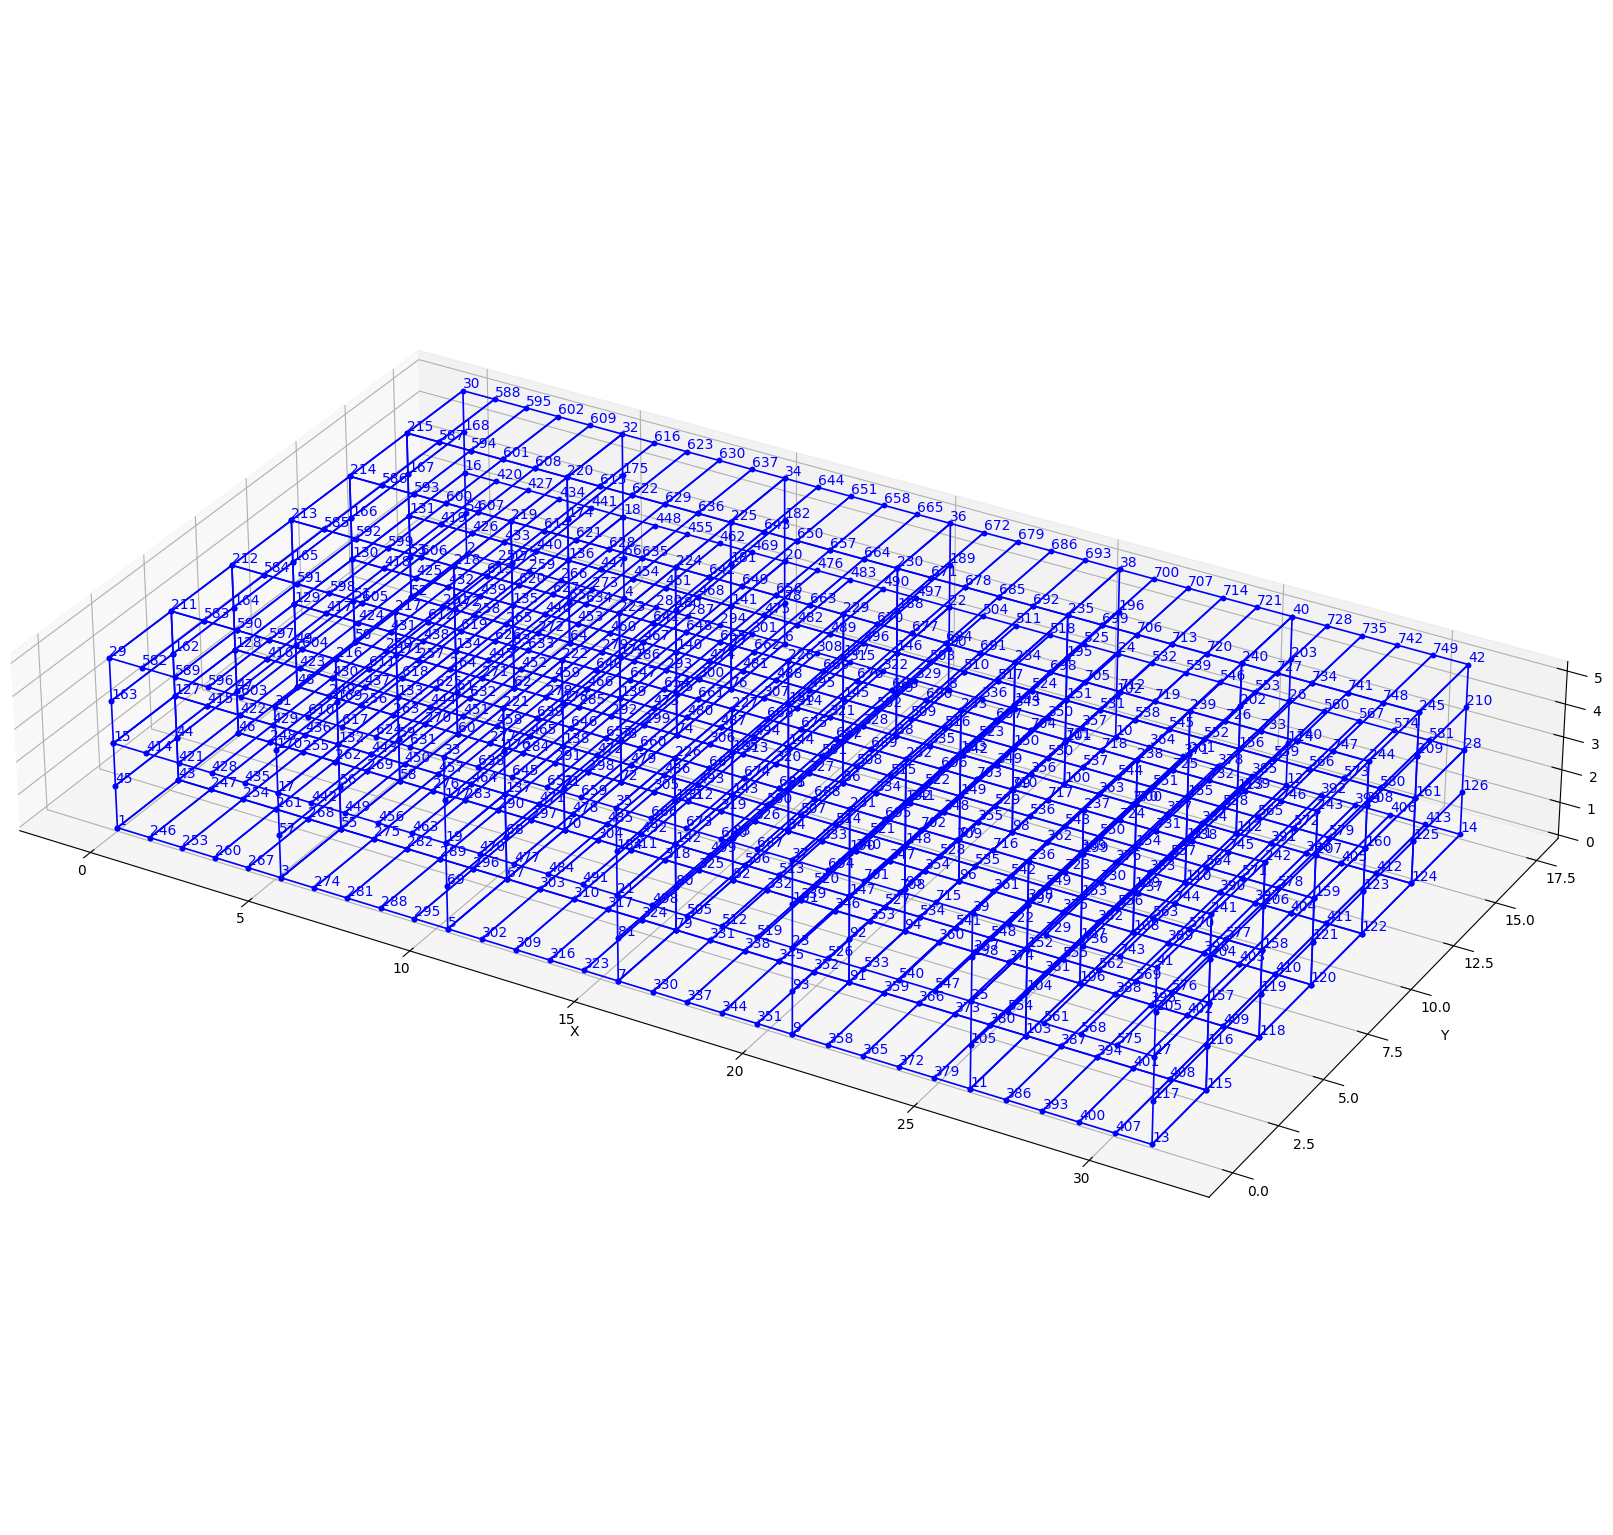

In [5]:
# plt.figure(figsize=(20, 10))
opsv.plot_model(fig_wi_he=(50, 50), node_labels=1, element_labels=0)

In [6]:
# Shift the coordinates by 15m to the left, this does not affect the model stiffness
footing_coord_x = footing_coord_x - 31.09/2 
# Prepare the ground deformation
vl = 2.0/100
dispX_gf, dispZ_gf = prepare_greenfield_disp(val_data_dir, vl, footing_coord_x)
Es = 25e6
nis = 0.25
mu_int = np.tan(30*np.pi/180)
footing_ele_width = l
footing_ele_length = b
footing_ele_width = np.array([footing_ele_width]*footing_nodes_ind.size).astype(float)
footing_ele_length= np.array([footing_ele_length]*footing_nodes_ind.size).astype(float)
qz = -1 * self_weight_unit
# footing_ele_length = ele_size_footing * np.ones_like(footing_nodes_ind).astype(float)
# footing_ele_width = bfoot * np.ones_like(footing_nodes_ind).astype(float)


# plot_verification(val_data_dir, 'FR2c2', 'q10', model.footing_coord_x, model, axes, model_el)


In [7]:
# footing
footing_nodes_ind = footing_nodes_ind - 1 # use index from 0


In [ ]:
model_el = ASREp.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elastic')
# model.set_soil_properties(Es, nis, mu_int)
model_el.set_soil_properties(Es, nis, mu_int)
# model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
model_el.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
# model_el.run_model(np.zeros_like(dispX_gf), np.zeros_like(dispX_gf), np.zeros_like(dispX_gf)-0.01, 'disp')
# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
#                                         figsize=(12, 6))

True

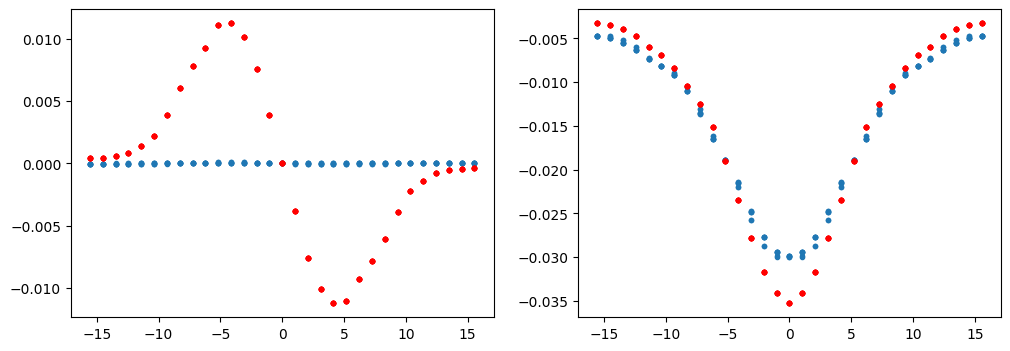

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 4))
axes[0].plot(footing_coord_x, model_el.result_array_ptr[footing_nodes_ind*6+0],'.', label = 'ASREp_el')
axes[0].plot(footing_coord_x, dispX_gf, 'r.', label = 'greenfield')
axes[1].plot(footing_coord_x, model_el.result_array_ptr[footing_nodes_ind*6+2],'.', label = 'ASREp_el')
axes[1].plot(footing_coord_x, dispZ_gf, 'r.', label = 'greenfield')

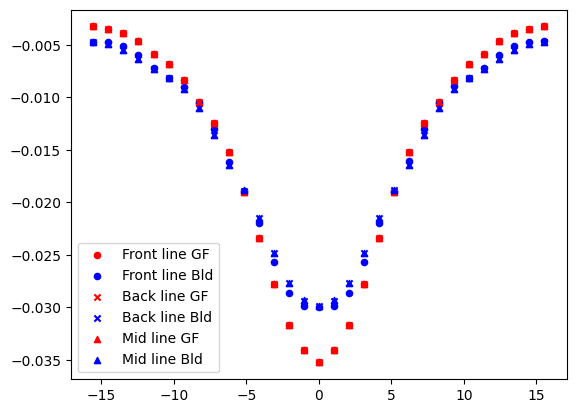

In [10]:
front_line_ind = np.concatenate((np.arange(1, 15, 2), np.arange(246, 408, 7))) - 1

mid_ind = []
for i in range(1, 750):
    if ops.nodeCoord(i)[1] == 8.772 and ops.nodeCoord(i)[2] == 0:
        mid_ind.append(i)
# back_line_ind = np.concatenate((np.arange(2, 15, 2), np.arange(252, 414, 7))) - 1
back_line_ind = []
for i in range(1, 750):
    if ops.nodeCoord(i)[1] == 2.924 and ops.nodeCoord(i)[2] == 0:
        back_line_ind.append(i)
mid_ind = np.array(mid_ind) - 1
back_line_ind = np.array(back_line_ind) - 1
front_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in front_line_ind]
back_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in back_line_ind]
mid_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in mid_ind]
plt.scatter(footing_coord_x[front_ind_in_footing], dispZ_gf[front_ind_in_footing], s=20, c='r', marker='o', label='Front line GF')
plt.scatter(footing_coord_x[front_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[front_ind_in_footing]*6 + 2], s=20, c='b', marker='o', label='Front line Bld')
plt.scatter(footing_coord_x[back_ind_in_footing], dispZ_gf[back_ind_in_footing], s=20, c='r', marker='x', label='Back line GF')
plt.scatter(footing_coord_x[back_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[back_ind_in_footing]*6 + 2], s=20, c='b', marker='x', label='Back line Bld')
plt.scatter(footing_coord_x[mid_ind_in_footing], dispZ_gf[mid_ind_in_footing], s=20, c='r', marker='^', label='Mid line GF')
plt.scatter(footing_coord_x[mid_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[mid_ind_in_footing]*6 + 2], s=20, c='b', marker='^', label='Mid line Bld')
plt.legend()

Text(0.5, 0, 'Displacement (mm)')

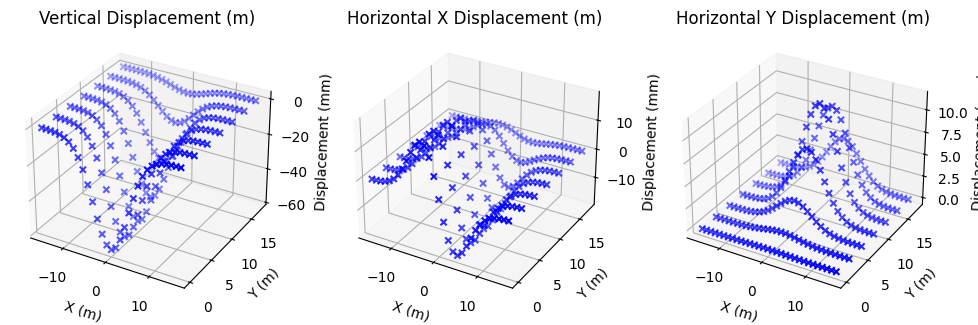

In [11]:
# Run analysis using a 3D ground deformation model
vl = 2.0/100
d = 6.0 
z0 = 7.9
ys = 2 * b * mq
yf = -10 * b * mq
k = 0.5
delta = 0.3
dispX_gf, dispY_gf, dispZ_gf = gdm.ground_disp_Zhao_2023(
    footing_coord_x, footing_coord_y, footing_coord_z,
    vl, d, z0, ys, yf, k, delta
)

# plot vertical displacements
fig, axes = plt.subplots(nrows=1, ncols=3,
                            figsize=(12, 4),
                            subplot_kw={'projection': '3d'})
axes[0].scatter(footing_coord_x, footing_coord_y, dispZ_gf*1000, c='b', marker='x', label='Greenfield')
axes[0].set_title('Vertical Displacement (m)')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_zlabel('Displacement (mm)')
axes[1].scatter(footing_coord_x, footing_coord_y, dispX_gf*1000, c='b', marker='x', label='Greenfield')
axes[1].set_title('Horizontal X Displacement (m)')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].set_zlabel('Displacement (mm)')
axes[2].scatter(footing_coord_x, footing_coord_y, dispY_gf*1000, c='b', marker='x', label='Greenfield')
axes[2].set_title('Horizontal Y Displacement (m)')
axes[2].set_xlabel('X (m)')
axes[2].set_ylabel('Y (m)')
axes[2].set_zlabel('Displacement (mm)')


In [12]:
model_el.run_model(dispX_gf, dispY_gf, dispZ_gf, 'disp')

True

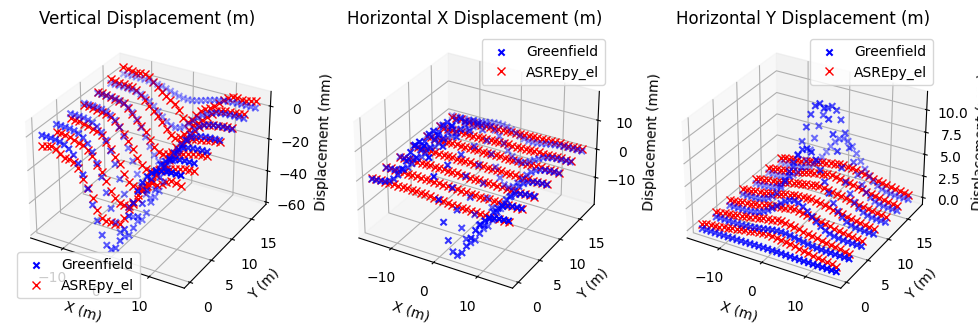

In [ ]:
# plot vertical displacements
fig, axes = plt.subplots(nrows=1, ncols=3,
                            figsize=(12, 4),
                            subplot_kw={'projection': '3d'})
axes[0].scatter(footing_coord_x, footing_coord_y, dispZ_gf*1000, c='b', marker='x', label='Greenfield')
axes[0].plot(footing_coord_x, footing_coord_y, model_el.result_array_ptr[footing_nodes_ind*6+2]*1000, 'rx', label='ASREp_el')
axes[0].set_title('Vertical Displacement (m)')
axes[0].set_xlabel('X (m)')
axes[0].set_ylabel('Y (m)')
axes[0].set_zlabel('Displacement (mm)')
axes[1].scatter(footing_coord_x, footing_coord_y, dispX_gf*1000, c='b', marker='x', label='Greenfield')
axes[1].plot(footing_coord_x, footing_coord_y, model_el.result_array_ptr[footing_nodes_ind*6]*1000, 'rx', label='ASREp_el')    
axes[1].set_title('Horizontal X Displacement (m)')
axes[1].set_xlabel('X (m)')
axes[1].set_ylabel('Y (m)')
axes[1].set_zlabel('Displacement (mm)')
axes[2].scatter(footing_coord_x, footing_coord_y, dispY_gf*1000, c='b', marker='x', label='Greenfield')
axes[2].plot(footing_coord_x, footing_coord_y, model_el.result_array_ptr[footing_nodes_ind*6+1]*1000, 'rx', label='ASREp_el')
axes[2].set_title('Horizontal Y Displacement (m)')
axes[2].set_xlabel('X (m)')
axes[2].set_ylabel('Y (m)')
axes[2].set_zlabel('Displacement (mm)')
# Add legend
axes[0].legend()
axes[1].legend()
axes[2].legend()

In [ ]:
qz = -1 * self_weight_unit
model = ASREp.ASRE_2D_frame_model(ops, footing_nodes_ind, footing_coord_x, 
                                   footing_coord_y, footing_coord_z,
                                   footing_ele_length, footing_ele_width, 
                                   qz, 'elasto-plastic')
model.set_soil_properties(Es, nis, mu_int)
start_time = time.time()
model.run_model(dispX_gf, np.zeros_like(dispX_gf), dispZ_gf, 'disp')
print(f"Model run time: {time.time() - start_time:.2f} seconds")
# model.run_model(np.zeros_like(dispX_gf), np.zeros_like(dispX_gf), np.zeros_like(dispZ_gf), 'disp')

Model run time: 193.01 seconds


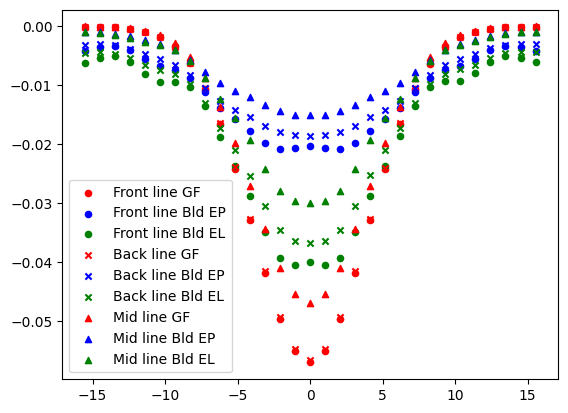

In [15]:
front_line_ind = np.concatenate((np.arange(1, 15, 2), np.arange(246, 408, 7))) - 1

mid_ind = []
for i in range(1, 750):
    if ops.nodeCoord(i)[1] == 8.772 and ops.nodeCoord(i)[2] == 0:
        mid_ind.append(i)
# back_line_ind = np.concatenate((np.arange(2, 15, 2), np.arange(252, 414, 7))) - 1
back_line_ind = []
for i in range(1, 750):
    if ops.nodeCoord(i)[1] == 2.924 and ops.nodeCoord(i)[2] == 0:
        back_line_ind.append(i)
mid_ind = np.array(mid_ind) - 1
back_line_ind = np.array(back_line_ind) - 1
front_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in front_line_ind]
back_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in back_line_ind]
mid_ind_in_footing = [np.where(footing_nodes_ind == i)[0][0] for i in mid_ind]
plt.scatter(footing_coord_x[front_ind_in_footing], dispZ_gf[front_ind_in_footing], s=20, c='r', marker='o', label='Front line GF')
plt.scatter(footing_coord_x[front_ind_in_footing], model.result_array_ptr[footing_nodes_ind[front_ind_in_footing]*6 + 2], s=20, c='b', marker='o', label='Front line Bld EP')
plt.scatter(footing_coord_x[front_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[front_ind_in_footing]*6 + 2], s=20, c='g', marker='o', label='Front line Bld EL')
plt.scatter(footing_coord_x[back_ind_in_footing], dispZ_gf[back_ind_in_footing], s=20, c='r', marker='x', label='Back line GF')
plt.scatter(footing_coord_x[back_ind_in_footing], model.result_array_ptr[footing_nodes_ind[back_ind_in_footing]*6 + 2], s=20, c='b', marker='x', label='Back line Bld EP')
plt.scatter(footing_coord_x[back_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[back_ind_in_footing]*6 + 2], s=20, c='g', marker='x', label='Back line Bld EL')
plt.scatter(footing_coord_x[mid_ind_in_footing], dispZ_gf[mid_ind_in_footing], s=20, c='r', marker='^', label='Mid line GF')
plt.scatter(footing_coord_x[mid_ind_in_footing], model.result_array_ptr[footing_nodes_ind[mid_ind_in_footing]*6 + 2], s=20, c='b', marker='^', label='Mid line Bld EP')
plt.scatter(footing_coord_x[mid_ind_in_footing], model_el.result_array_ptr[footing_nodes_ind[mid_ind_in_footing]*6 + 2], s=20, c='g', marker='^', label='Mid line Bld EL')
plt.legend()

In [16]:
# Run an analysis using 3D ground deformation model
